In [ ]:
!pip install plot_model

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Thu Mar  7 00:04:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#!pip uninstall tensorflow
#!pip install --ignore-installed --upgrade tensorflow

In [ ]:
#!pip install --user tensorflow
#!pip install --user keras
!pip install pydotplus
!pip install graphviz

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
#!pip show keras

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

import os
import keras
#import tensorflow.python.keras.utils.vis_utils
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder, label_binarize

import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from xgboost import XGBClassifier # XGBClassifier


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading files
# Four categories
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [ ]:
# How many samples in each category:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

66877
7073
5002
488


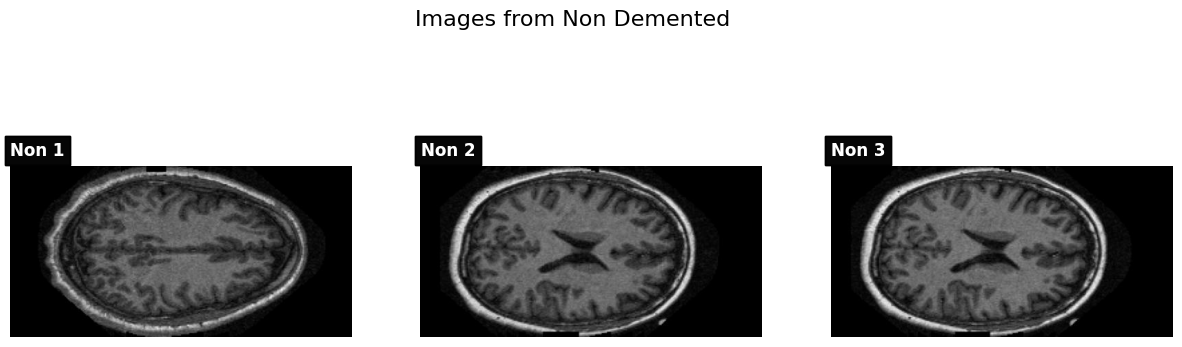

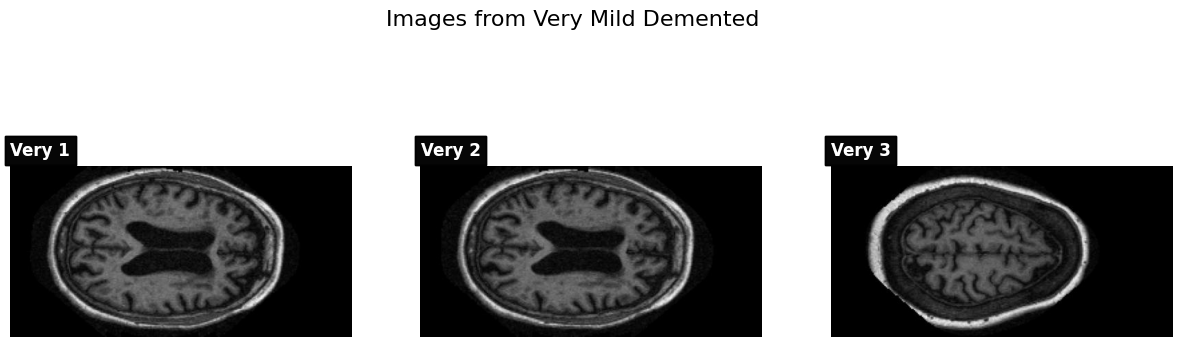

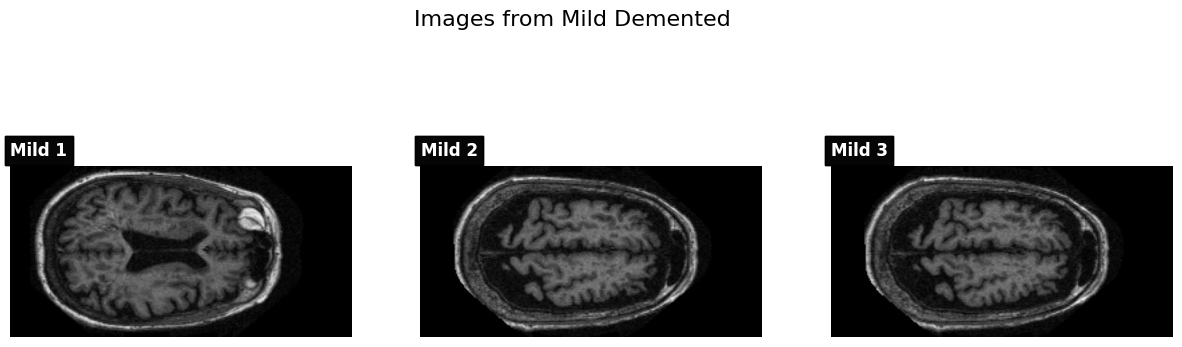

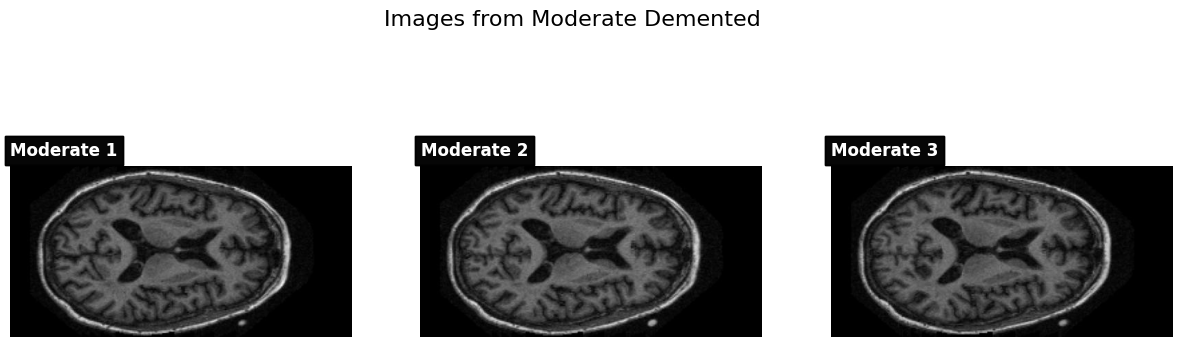

In [ ]:
# Function to display images with text indicating the category
def display_images_with_text(file_paths, category_name, endings=['150', '151', '152']):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    for ending in endings:
        matching_files = [img for img in file_paths if img.endswith(ending + '.jpg')]
        for i in range(min(3, len(matching_files))):
            img_path = matching_files[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
             # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {i + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()

# Display images with text for each category
display_images_with_text(non_demented, "Non Demented")
display_images_with_text(very_mild_demented, "Very Mild Demented")
display_images_with_text(mild_demented, "Mild Demented")
display_images_with_text(moderate_demented, "Moderate Demented")


In [ ]:
def validate_filename(filename):
    """
    Validate filename to ensure it is a valid OASIS Alzheimer's dataset filename.
    """
    pattern = re.compile('OAS1_\d+_MR\d+_mpr-\d+_\d+.jpg')
    return bool(pattern.match(filename))

In [ ]:
import re
def get_info_from_filename(filename):
    pattern = re.compile('OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [ ]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    # Iterate through folders in the dataset_path
    for folder in os.listdir(dataset_path):

        # Iterate through files in each folder
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if not validate_filename(file):
                raise ValueError(f'Invalid filename: {folder}/{file}')
            # Extract information from the filename using get_info_from_filename function
            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

             # Append information to respective lists
            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

             # Create a DataFrame from the collected information
    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })
# Convert columns to appropriate data types
    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'string',
        'mr_id': 'string',
        'scan_id': 'string',
        'layer_id': 'string'
    })

    return ref_df

In [ ]:
# Applying the function defined above
ref_df = create_ref_df('/content/drive/MyDrive/OASIS Alzheimer_s Dataset')

In [ ]:
# displaying the DataFrame
display(ref_df)

,path,label,patient_id,mr_id,scan_id,layer_id
0,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,137
1,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,141
2,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,133
3,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,151
4,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,140
...,...,...,...,...,...,...
79435,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,150
79436,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,154
79437,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,141
79438,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,2,102


In [ ]:
#secend version for fast exeqution
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import pandas as pd


def process_image(row, volume):
    layer_id = int(row['layer_id'])
    if 100 <= layer_id <= 160:  # Ensure layer_id is within valid range
        image = imread(row['path'], as_gray=True)
        resized_image = resize(image, (248, 496))
        volume[layer_id - 100, :, :] = (resized_image * 255).astype(np.uint8)
    else:
        print(f"Ignoring invalid layer_id {layer_id} for {row['path']}")

def create_volumes_V2(ref_df):
    volumes = []

    # Group DataFrame by patient_id and scan_id
    grouped_df = ref_df.groupby(['patient_id', 'scan_id'])

    # Iterate over groups
    for _, group in grouped_df:
        # Count the total number of unique layer IDs
        total_layer_ids = group['layer_id'].nunique()

        # Check if the total number of layer IDs is exactly 61
        if total_layer_ids != 61:
            print(f"Ignoring group with invalid number of layer IDs ({total_layer_ids} instead of 61)")
            continue

        # Initialize volume for current scan
        volume = np.zeros((61, 248, 496), dtype=np.uint8)

        # Process images in parallel
        group.apply(process_image, axis=1, args=(volume,))

        # Append volume to list of volumes
        volumes.append(volume)

    return volumes



In [ ]:
volumes = create_volumes_V2(ref_df)

In [ ]:

# Assuming volumes is a list of volumes generated by create_volumes function
volumes_array = np.array(volumes)

# Now volumes_array is a NumPy array containing all the volumes
print(volumes_array)

In [ ]:
import numpy as np

# Convert volumes list to NumPy array
volumes_array = np.array(volumes)

# Get the size of the array in bytes
array_size_bytes = volumes_array.nbytes

# Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
array_size_mb = array_size_bytes / (1024 * 1024)

print(f"Size of the data in memory: {array_size_mb:.2f} MB")


Size of the data in memory: 8751.65 MB


In [ ]:
print("Length of volumes_array:", len(volumes_array))

Length of volumes_array: 1223


In [ ]:
print("Length of volumes_array:", len(volumes_array))

Length of volumes_array: 1223


In [ ]:
volumes_array.shape

(1223, 61, 248, 496)

In [ ]:
from google.colab import drive
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the directory containing the .pkl file
os.chdir('/content/drive/MyDrive/Alzheimer_s Dataset/')

# Load the volumes_array.pkl file
with open('volumes_array.pkl', 'rb') as f:
    volumes_array = pickle.load(f)

# Load the labels_array.pkl file if available
with open('labels_array1.pkl', 'rb') as f:
    labels_array = pickle.load(f)

# Display the length of volumes_array
print("Length of volumes_array:", len(volumes_array))

# Display the length of volumes_array
print("Length of volumes_array:", len(labels_array))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Length of volumes_array: 1223
Length of volumes_array: 1223


In [ ]:
volumes_array.shape

(1223, 61, 248, 496)

In [ ]:
labels_array.shape

(1223,)

In [ ]:
# Split volumes and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(volumes_array, labels_array, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train.shape

(978, 61, 248, 496)

In [ ]:
from skimage.transform import resize
import numpy as np

# Resize each slice of the volume to (128, 128)
X_train_resized = np.zeros((X_train.shape[0], 61, 128, 128, 3))

for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train_resized[i, j] = resize(X_train[i, j], (128, 128, 3), mode='constant')

# Now X_train_resized has the shape (978, 61, 128, 128, 3)

In [ ]:
X_train_resized.shape

(550, 61, 128, 128, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/X_train_resized.npy', X_train_resized)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/X_train_resized.npy'
X_train = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_train.shape)

Loaded array shape: (550, 61, 128, 128, 3)


In [ ]:
from skimage.transform import resize
import numpy as np

# Resize each slice of the volume to (128, 128)
X_test_resized = np.zeros((X_test.shape[0], 61, 128, 128, 3))

for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test_resized[i, j] = resize(X_test[i, j], (128, 128, 3), mode='constant')

# Now X_train_resized has the shape (978, 61, 128, 128, 3)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/X_test_resized.npy', X_test_resized)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/X_test_resized.npy'
X_test = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", X_test.shape)

Loaded array shape: (245, 61, 128, 128, 3)


In [ ]:
X_test_resized.shape

In [ ]:
X_test.shape

(245, 61, 128, 128, 3)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/y_train3_3D.npy'
y_train = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_train.shape)

Loaded array shape: (550,)


In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/y_test_3D.npy'
y_test = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", y_test.shape)

Loaded array shape: (245,)


In [ ]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

def process_image(row, volume):
    layer_id = int(row['layer_id'])
    if 100 <= layer_id <= 160:  # Ensure layer_id is within valid range
        image = imread(row['path'], as_gray=True)
        resized_image = resize(image, (248, 496))
        volume[layer_id - 100, :, :] = (resized_image * 255).astype(np.uint8)
    else:
        print(f"Ignoring invalid layer_id {layer_id} for {row['path']}")

def create_volumes_V4(ref_df):
    volumes = []
    labels = []

    # Group DataFrame by patient_id and scan_id
    grouped_df = ref_df.groupby(['patient_id', 'scan_id'])

    # Iterate over groups
    for _, group in grouped_df:
        # Count the total number of unique layer IDs
        total_layer_ids = group['layer_id'].nunique()

        # Check if the total number of layer IDs is exactly 61
        if total_layer_ids != 61:
            print(f"Ignoring group with invalid number of layer IDs ({total_layer_ids} instead of 61)")
            continue

        # Initialize volume for current scan
        volume = np.zeros((61, 248, 496), dtype=np.uint8)

        # Process images and labels in parallel
        for index, row in group.iterrows():
            process_image(row, volume)

        # Append volume to list of volumes
        volumes.append(volume)

        # Get label for this group
        label = group['label'].iloc[0]  # Assuming label is the same for all rows in the group
        labels.append(label)

    return volumes, labels


In [ ]:
volumes_array1, labels_array1 = create_volumes_V4(ref_df)

Ignoring group with invalid number of layer IDs (38 instead of 61)
Ignoring group with invalid number of layer IDs (57 instead of 61)
Ignoring group with invalid number of layer IDs (56 instead of 61)
Ignoring group with invalid number of layer IDs (60 instead of 61)
Ignoring group with invalid number of layer IDs (17 instead of 61)
Ignoring group with invalid number of layer IDs (4 instead of 61)
Ignoring group with invalid number of layer IDs (60 instead of 61)
Ignoring group with invalid number of layer IDs (20 instead of 61)
Ignoring group with invalid number of layer IDs (47 instead of 61)
Ignoring group with invalid number of layer IDs (60 instead of 61)


In [ ]:
print(len(volumes_array1))
print(len(labels_array1))

In [ ]:
# Assuming volumes is a list of volumes generated by create_volumes function
labels_array1 = np.array(labels_array1)

# Now volumes_array is a NumPy array containing all the volumes
print(labels_array1)

['Non Demented' 'Non Demented' 'Non Demented' ... 'Mild Dementia'
 'Mild Dementia' 'Mild Dementia']


In [ ]:
import numpy as np
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the array
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/volumes_array1.pkl'

# Save the NumPy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(volumes_array1, file)

print(f"NumPy array saved to {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assuming volumes is a list of volumes generated by create_volumes function
labels_array1 = np.array(volumes_array1)

# Now volumes_array is a NumPy array containing all the volumes
print(volumes_array1)

[array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [ ]:
#============================= till now is ok =========================

In [ ]:
# Split in validation and train data
x_train,x_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.20, shuffle=True, random_state=42)

The data pre-processing thus resulted in the following data objects:

x_train: train data

y_train: train labels

x_val: validation data (used in training/modeling)

y_val: validation labels (used in training/modeling)

x_test: test data (evaluation after modeling)

y_test: test labels (evaluation after modeling)


In [ ]:
from tensorflow.keras.layers import Input, Reshape, Concatenate, Lambda
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf

# Define input shape for a single image
input_shape = (128, 128, 3)  # Height, width, and number of channels

# Define input tensor for batch of 61 images
input_tensor = Input(shape=(61,) + input_shape)  # Shape: (batch_size, height, width, channels)

# Reshape input tensor to match InceptionV3 input shape
reshaped_input = Reshape((-1, input_shape[0], input_shape[1], input_shape[2]))(input_tensor)

# Concatenate along the channel dimension
concatenated_input = Lambda(lambda x: tf.concat(x, axis=-1))(tf.unstack(reshaped_input, axis=1))

# Create InceptionV3 model with specified input shape
inception_model = InceptionV3(input_shape=(input_shape[0], input_shape[1], input_shape[2]), include_top=False, weights="imagenet")(concatenated_input)

In [ ]:
for layer in inception_model.layers:
  layer.trainable=False

In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 63, 63, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 63, 63, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:
custom_inception_model = Sequential([
      inception_model,
      Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4)
      ], name = "inception_cnn_model")

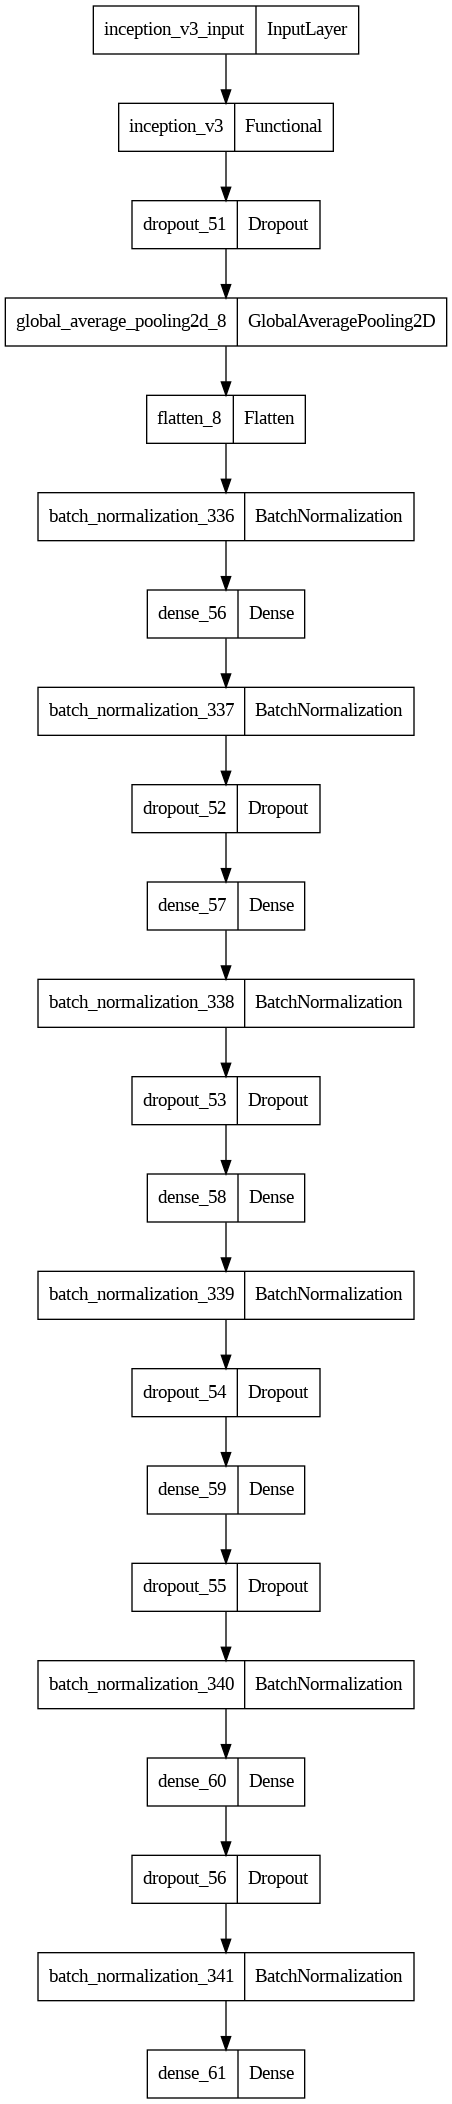

In [ ]:
plot_model(custom_inception_model)

Training: Regular Classification

In [ ]:
from tensorflow.keras.models import clone_model
custom_inception_model_rc = clone_model(custom_inception_model)

In [ ]:
# Compile with ('regular') categorical_crossentropy
# Adam optimizer with learning rate 0.001
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
custom_inception_model_rc.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

In [ ]:
EPOCHS = 30
history_rc = custom_inception_model_rc.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping],epochs=EPOCHS)

In [ ]:
X_train_flat.shape
X_test_flat.shape

In [ ]:
feature_extractor_Train=custom_inception_model.predict(x_train)



In [ ]:
#feature_extractor_val=custom_inception_model.predict(x_val)
feature_extractor_test=custom_inception_model.predict(X_test)

In [ ]:
feature_extractor_test.shape

(2018, 4)

In [ ]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set
testeval = custom_inception_model.evaluate(x_test, y_test_int, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

497/497 - 119s - loss: 13.0064 - accuracy: 0.0607 - 119s/epoch - 240ms/step
Test Loss: 13.006393432617188
Test Accuracy: 0.060730017721652985


In [ ]:
#Results on Test Set
y_test_int = np.argmax(y_test, axis=1)
# Evaluate on test set
testeval = custom_inception_model_rc.evaluate(x_test, y_test, verbose=2)

# Printing performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])


497/497 - 116s - loss: 1.6284 - accuracy: 0.1117 - 116s/epoch - 234ms/step
Test Loss: 1.6283974647521973
Test Accuracy: 0.1117054745554924


In [ ]:
params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'missing': 1,
    'n_estimators': 100,
    'n_jobs': -1,
    'nthread': None,
    'random_state': 1855,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': None,
    'silent': None,
    'subsample': 1,
    'verbosity': 0,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 7,
    # Set number of GPUs if available
    'n_gpus': 0,
    'predictor': 'gpu_predictor'
}

modelXG = XGBClassifier(**params)

In [ ]:
modelXG.fit(feature_extractor_Train,y_train_int)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=None,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=1, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_gpus=0, n_jobs=-1, nthread=None, ...)

In [ ]:
XG_test_pred = modelXG.predict(feature_extractor_test)

In [ ]:
y_test_int.shape


(2018,)

In [ ]:
XG_test_pred.shape

(2018,)

In [ ]:
targetnames = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]
print(classification_report(y_test_int, XG_test_pred, target_names=targetnames))

                    precision    recall  f1-score   support

      non_demented       0.93      0.52      0.67     13376
very_mild_demented       0.14      0.30      0.19      1415
 moderate_demented       0.12      0.35      0.18      1001
     mild_demented       0.01      0.37      0.03        98

          accuracy                           0.49     15890
         macro avg       0.30      0.38      0.27     15890
      weighted avg       0.80      0.49      0.59     15890



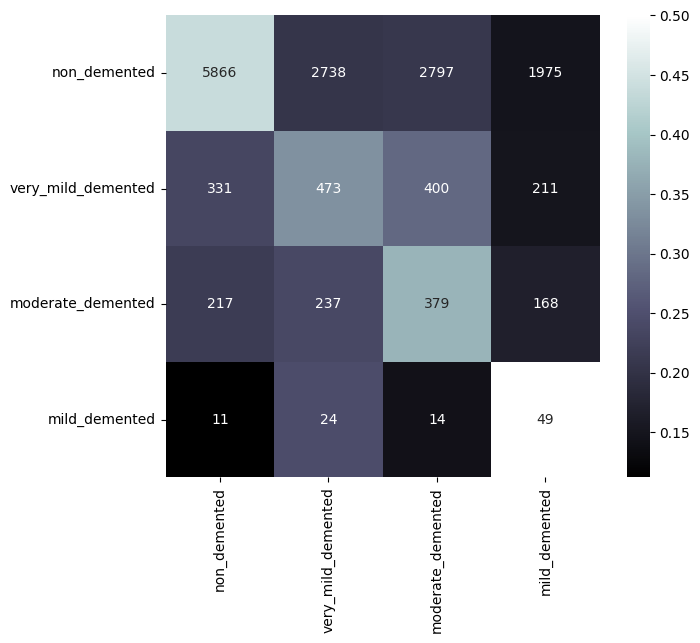

In [ ]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

cm = confusion_matrix(y_test_int,XG_test_pred)
plot_confusion_matrix(cm, targetnames)